In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import time
import json
import os
import cv2
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection
from sklearn.model_selection import train_test_split

In [2]:
# gpu setting 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda:0 is available


In [3]:
# folder path 지정(0~N까지의 Class로 지정되어 있어야 함)
folder_path = './drones/'
token_class_folder = os.listdir(folder_path) # folder name 나누기

num_classes = len(token_class_folder) # class num == folder 개수

# data와 label list 선언
data = []
label = []

# class 만큼 반복
for token_c in token_class_folder:
    # folder 안에 들어있는 이미지 정보 가져오기
    token_img_folder = os.listdir(folder_path + "/" + token_c)
    # 이미지 정보만큼 반복
    for token_i in token_img_folder:
        # 이미지 열기
        img = Image.open(folder_path + "/" + token_c + "/" + token_i)
        # VGG11에 사용할 수 있도록 resize
        resize_img = img.resize((224, 224))
        # r, g, b 채널로 각각 나누기
        r, g, b = resize_img.split()
        # 각 쪼갠 이미지를 255로 나눠서 0~1 사이의 값이 나오도록 정규화
        r_resize_img = np.asarray(np.float32(r) / 255.0)
        b_resize_img = np.asarray(np.float32(g) / 255.0)
        g_resize_img = np.asarray(np.float32(b) / 255.0)
        
        # 가공한 이미지 붙이기
        rgb_resize_img = np.asarray([r_resize_img, b_resize_img, g_resize_img])
        # 가공 이미지 추가
        data.append(rgb_resize_img)
        # 라벨 추가
        label.append(int(token_c))

# shape 확인해보기(224, 224가 나와야함)
pd.DataFrame(data[0][0]).shape

(224, 224)

In [4]:
# pytorch에서 사용할 수 있도록 지정하기
data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

train_X, test_X, train_Y, test_Y = model_selection.train_test_split(data, label, test_size=0.05)

train_X = torch.from_numpy(train_X).float()
train_Y = torch.from_numpy(train_Y).long()

test_X = torch.from_numpy(test_X).float()
test_Y = torch.from_numpy(test_Y).long()

train = TensorDataset(train_X, train_Y)
test = TensorDataset(test_X, test_Y)

# dataset 최종본
trainloader = DataLoader(train, batch_size=4, shuffle=True)
testloader = DataLoader(test, batch_size = 4, shuffle = False)

In [5]:
# VGG11 model
class VGG_A(nn.Module):
    def __init__(self, num_classes: int = 1000, init_weights: bool = True):
        super(VGG_A, self).__init__()
        self.convnet = nn.Sequential(
            # Input Channel (RGB: 3)
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 224 -> 112

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 112 -> 56

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 56 -> 28

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 28 -> 14

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 14 -> 7
        )

        self.fclayer = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
            # nn.Softmax(dim=1), # Loss인 Cross Entropy Loss 에서 softmax 포함
        )

    def forward(self, x:torch.Tensor):
        x = self.convnet(x)
        x = torch.flatten(x, 1)
        x = self.fclayer(x)
        return x

In [8]:
# GPU 사용하자
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model을 fitting
vgg11 = VGG_A(num_classes = 6)
vgg11 = vgg11.to(device)


# 클래스 지정해주기(이름!!)
classes =  ('DJI_Air2S', 'DJI_FPVcomdo', 'DJI_Mini2', 'DJI_Phatom4Pro', 'DJI_Tello', 'DJI_Phantom3')

criterion = nn.CrossEntropyLoss().cuda()

# Optimizer 초기화
optimizer = optim.Adam(vgg11.parameters(),lr=0.00001)


In [9]:
# 모델 한 번씩 확인해보기
import torchsummary
torchsummary.summary(vgg11, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         590,080
             ReLU-10          [-1, 256, 56, 56]               0
        MaxPool2d-11          [-1, 256, 28, 28]               0
           Conv2d-12          [-1, 512, 28, 28]       1,180,160
             ReLU-13          [-1, 512, 28, 28]               0
           Conv2d-14          [-1, 512,

In [10]:
### 학습 시키기!!!!!!!!!!!!!!!!!!

loss_list = []
epoch_list = []

start_time = time.time()
for epoch in range(100):  # loop over the dataset multiple times
    epoch_list.append(epoch) # epoch 넣기...
    running_loss = 0.0
    loss_list.append(0)
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # print(inputs.shape)  
        outputs= vgg11(inputs)

        # print(outputs.shape)
        # print(labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            loss_list[epoch] = running_loss/50
            running_loss = 0.0
        
    print(time.time()-start_time)
print(time.time()-start_time)
print('Finished Training')

[1,    50] loss: 1.792
[1,   100] loss: 1.792
[1,   150] loss: 1.791
[1,   200] loss: 1.791
[1,   250] loss: 1.793
[1,   300] loss: 1.794
[1,   350] loss: 1.792
[1,   400] loss: 1.792
[1,   450] loss: 1.789
[1,   500] loss: 1.781
[1,   550] loss: 1.732
[1,   600] loss: 1.704
[1,   650] loss: 1.615
[1,   700] loss: 1.573
[1,   750] loss: 1.570
[1,   800] loss: 1.599
[1,   850] loss: 1.534
58.93772220611572
[2,    50] loss: 1.529
[2,   100] loss: 1.599
[2,   150] loss: 1.522
[2,   200] loss: 1.489
[2,   250] loss: 1.393
[2,   300] loss: 1.540
[2,   350] loss: 1.451
[2,   400] loss: 1.492
[2,   450] loss: 1.320
[2,   500] loss: 1.465
[2,   550] loss: 1.462
[2,   600] loss: 1.433
[2,   650] loss: 1.470
[2,   700] loss: 1.384
[2,   750] loss: 1.426
[2,   800] loss: 1.429
[2,   850] loss: 1.289
117.66845440864563
[3,    50] loss: 1.276
[3,   100] loss: 1.299
[3,   150] loss: 1.361
[3,   200] loss: 1.275
[3,   250] loss: 1.397
[3,   300] loss: 1.243
[3,   350] loss: 1.306
[3,   400] loss: 1.2

[20,   600] loss: 0.092
[20,   650] loss: 0.064
[20,   700] loss: 0.051
[20,   750] loss: 0.063
[20,   800] loss: 0.068
[20,   850] loss: 0.093
1169.790628194809
[21,    50] loss: 0.033
[21,   100] loss: 0.073
[21,   150] loss: 0.065
[21,   200] loss: 0.023
[21,   250] loss: 0.046
[21,   300] loss: 0.024
[21,   350] loss: 0.016
[21,   400] loss: 0.064
[21,   450] loss: 0.016
[21,   500] loss: 0.046
[21,   550] loss: 0.076
[21,   600] loss: 0.145
[21,   650] loss: 0.141
[21,   700] loss: 0.100
[21,   750] loss: 0.065
[21,   800] loss: 0.095
[21,   850] loss: 0.071
1228.7810871601105
[22,    50] loss: 0.078
[22,   100] loss: 0.043
[22,   150] loss: 0.029
[22,   200] loss: 0.058
[22,   250] loss: 0.035
[22,   300] loss: 0.058
[22,   350] loss: 0.054
[22,   400] loss: 0.034
[22,   450] loss: 0.055
[22,   500] loss: 0.039
[22,   550] loss: 0.036
[22,   600] loss: 0.019
[22,   650] loss: 0.033
[22,   700] loss: 0.054
[22,   750] loss: 0.060
[22,   800] loss: 0.104
[22,   850] loss: 0.073
128

[39,   800] loss: 0.040
[39,   850] loss: 0.011
2591.8070595264435
[40,    50] loss: 0.005
[40,   100] loss: 0.051
[40,   150] loss: 0.012
[40,   200] loss: 0.012
[40,   250] loss: 0.012
[40,   300] loss: 0.005
[40,   350] loss: 0.007
[40,   400] loss: 0.002
[40,   450] loss: 0.007
[40,   500] loss: 0.012
[40,   550] loss: 0.034
[40,   600] loss: 0.002
[40,   650] loss: 0.007
[40,   700] loss: 0.001
[40,   750] loss: 0.019
[40,   800] loss: 0.049
[40,   850] loss: 0.021
2651.0623800754547
[41,    50] loss: 0.011
[41,   100] loss: 0.018
[41,   150] loss: 0.025
[41,   200] loss: 0.023
[41,   250] loss: 0.069
[41,   300] loss: 0.013
[41,   350] loss: 0.022
[41,   400] loss: 0.009
[41,   450] loss: 0.014
[41,   500] loss: 0.004
[41,   550] loss: 0.003
[41,   600] loss: 0.001
[41,   650] loss: 0.001
[41,   700] loss: 0.026
[41,   750] loss: 0.019
[41,   800] loss: 0.002
[41,   850] loss: 0.083
2710.041784763336
[42,    50] loss: 0.040
[42,   100] loss: 0.009
[42,   150] loss: 0.003
[42,   2

[59,   100] loss: 0.001
[59,   150] loss: 0.001
[59,   200] loss: 0.000
[59,   250] loss: 0.001
[59,   300] loss: 0.002
[59,   350] loss: 0.001
[59,   400] loss: 0.001
[59,   450] loss: 0.000
[59,   500] loss: 0.031
[59,   550] loss: 0.016
[59,   600] loss: 0.002
[59,   650] loss: 0.005
[59,   700] loss: 0.001
[59,   750] loss: 0.002
[59,   800] loss: 0.001
[59,   850] loss: 0.000
3763.9182801246643
[60,    50] loss: 0.006
[60,   100] loss: 0.001
[60,   150] loss: 0.006
[60,   200] loss: 0.001
[60,   250] loss: 0.001
[60,   300] loss: 0.000
[60,   350] loss: 0.000
[60,   400] loss: 0.001
[60,   450] loss: 0.001
[60,   500] loss: 0.000
[60,   550] loss: 0.000
[60,   600] loss: 0.006
[60,   650] loss: 0.000
[60,   700] loss: 0.001
[60,   750] loss: 0.007
[60,   800] loss: 0.008
[60,   850] loss: 0.002
3822.675801038742
[61,    50] loss: 0.001
[61,   100] loss: 0.000
[61,   150] loss: 0.000
[61,   200] loss: 0.000
[61,   250] loss: 0.000
[61,   300] loss: 0.000
[61,   350] loss: 0.000
[61

[78,   300] loss: 0.002
[78,   350] loss: 0.001
[78,   400] loss: 0.008
[78,   450] loss: 0.003
[78,   500] loss: 0.001
[78,   550] loss: 0.000
[78,   600] loss: 0.006
[78,   650] loss: 0.001
[78,   700] loss: 0.000
[78,   750] loss: 0.001
[78,   800] loss: 0.000
[78,   850] loss: 0.001
4876.640772104263
[79,    50] loss: 0.000
[79,   100] loss: 0.001
[79,   150] loss: 0.001
[79,   200] loss: 0.000
[79,   250] loss: 0.000
[79,   300] loss: 0.000
[79,   350] loss: 0.000
[79,   400] loss: 0.000
[79,   450] loss: 0.001
[79,   500] loss: 0.001
[79,   550] loss: 0.000
[79,   600] loss: 0.001
[79,   650] loss: 0.000
[79,   700] loss: 0.001
[79,   750] loss: 0.001
[79,   800] loss: 0.002
[79,   850] loss: 0.000
4935.157586336136
[80,    50] loss: 0.000
[80,   100] loss: 0.056
[80,   150] loss: 0.013
[80,   200] loss: 0.000
[80,   250] loss: 0.009
[80,   300] loss: 0.002
[80,   350] loss: 0.052
[80,   400] loss: 0.176
[80,   450] loss: 0.003
[80,   500] loss: 0.003
[80,   550] loss: 0.003
[80,

[97,   550] loss: 0.000
[97,   600] loss: 0.000
[97,   650] loss: 0.000
[97,   700] loss: 0.000
[97,   750] loss: 0.000
[97,   800] loss: 0.000
[97,   850] loss: 0.000
5988.9292867183685
[98,    50] loss: 0.000
[98,   100] loss: 0.000
[98,   150] loss: 0.000
[98,   200] loss: 0.000
[98,   250] loss: 0.000
[98,   300] loss: 0.000
[98,   350] loss: 0.000
[98,   400] loss: 0.000
[98,   450] loss: 0.000
[98,   500] loss: 0.000
[98,   550] loss: 0.000
[98,   600] loss: 0.000
[98,   650] loss: 0.000
[98,   700] loss: 0.000
[98,   750] loss: 0.000
[98,   800] loss: 0.000
[98,   850] loss: 0.000
6047.473484754562
[99,    50] loss: 0.000
[99,   100] loss: 0.000
[99,   150] loss: 0.000
[99,   200] loss: 0.000
[99,   250] loss: 0.000
[99,   300] loss: 0.000
[99,   350] loss: 0.003
[99,   400] loss: 0.001
[99,   450] loss: 0.008
[99,   500] loss: 0.006
[99,   550] loss: 0.092
[99,   600] loss: 0.170
[99,   650] loss: 0.112
[99,   700] loss: 0.164
[99,   750] loss: 0.010
[99,   800] loss: 0.002
[99

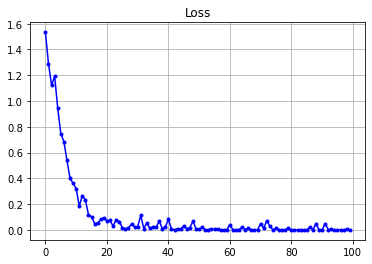

In [12]:
# loss 시각화...
import matplotlib.pyplot as plt
plt.title("Loss")
plt.plot(epoch_list, loss_list, marker='.', c = 'blue')
plt.grid()
plt.savefig('fig_loss.png', dpi=300)
plt.show()

In [13]:
# model 저장 -> 저장한 모델은 불러와서 사용 가능함
model = torch.jit.script(vgg11)
model.save('./vgg11.pth')

In [15]:
# class 별로 정확도 출력시키기
accuracy = []

class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = vgg11(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(2):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        accuracy.append(class_correct[i]/class_total[i])

for i in range(6): # 6은 클래스 수...
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of DJI_Air2S : 75 %
Accuracy of DJI_FPVcomdo : 82 %
Accuracy of DJI_Mini2 : 60 %
Accuracy of DJI_Phatom4Pro : 68 %
Accuracy of DJI_Tello : 84 %
Accuracy of DJI_Phantom3 : 100 %
